In [90]:
import pandas as pd
import nltk
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
from matplotlib import pyplot
import warnings
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.probability import FreqDist
import spacy
import en_core_web_sm
import itertools

In [3]:
listings = pd.read_csv('./data/listings.csv')
listings_sum = pd.read_csv('./data/listings_sum.csv')

In [4]:
listings.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1944,https://www.airbnb.com/rooms/1944,20190711004031,2019-07-11,cafeheaven Pberg/Mitte/Wed for the summer 2019,"Private, bright and friendly room. You'd be sh...","The room is very large, private, cozy, bright,...","Private, bright and friendly room. You'd be sh...",none,near all the trendy cafés and flea markets and...,...,f,f,moderate,f,f,1,0,1,0,0.25


In [5]:
listings.shape

(24395, 106)

In [6]:
listings_sum.head(1)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,1944,cafeheaven Pberg/Mitte/Wed for the summer 2019,2164,Lulah,Mitte,Brunnenstr. Nord,52.54425,13.39749,Private room,21,120,18,2018-11-11,0.25,1,364


In [7]:
listings_sum.shape

(24395, 16)

In [8]:
# checking how many observations for the neighborhoods we have

listings_sum['neighbourhood_group'].value_counts()

Friedrichshain-Kreuzberg    5854
Mitte                       5082
Pankow                      3818
Neukölln                    3753
Charlottenburg-Wilm.        1766
Tempelhof - Schöneberg      1610
Lichtenberg                  792
Treptow - Köpenick           647
Steglitz - Zehlendorf        489
Reinickendorf                304
Marzahn - Hellersdorf        142
Spandau                      138
Name: neighbourhood_group, dtype: int64

In [9]:
# joining listings with names of the neighborhoods

neighborhoods = listings_sum[['id', 'neighbourhood_group']]
listings = listings.join(neighborhoods.set_index('id'), on='id')

In [10]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [10]:
# replacing all non-English words, numbers, punctuation, stopwords
words = set(nltk.corpus.words.words())
stop_words=set(stopwords.words("english"))

def non_eng_rem(x):
    return " ".join(w.lower() for w in nltk.wordpunct_tokenize(x) \
         if w.lower() in words and w.lower() not in stop_words and w.isalpha())

listings['description_cleaned'] = listings['description'].apply(lambda x: non_eng_rem(str(x)))
listings = listings.dropna(subset=['description_cleaned'])

In [11]:
# uniting the texts on the base of the neighborhoods

listings_agg = listings.groupby('neighbourhood_group')['description_cleaned'].apply(lambda x: ''.join(str(list(x)))).reset_index()

## How different the Berlin neighbourhoods based on the text descriptions from AirBnB?

In [279]:
# creating document-term matrix
vectorizer = CountVectorizer(input='content')
dtm = vectorizer.fit_transform(listings_agg['description_cleaned'])
vocab = np.array(vectorizer.get_feature_names())
dtm = dtm.toarray()

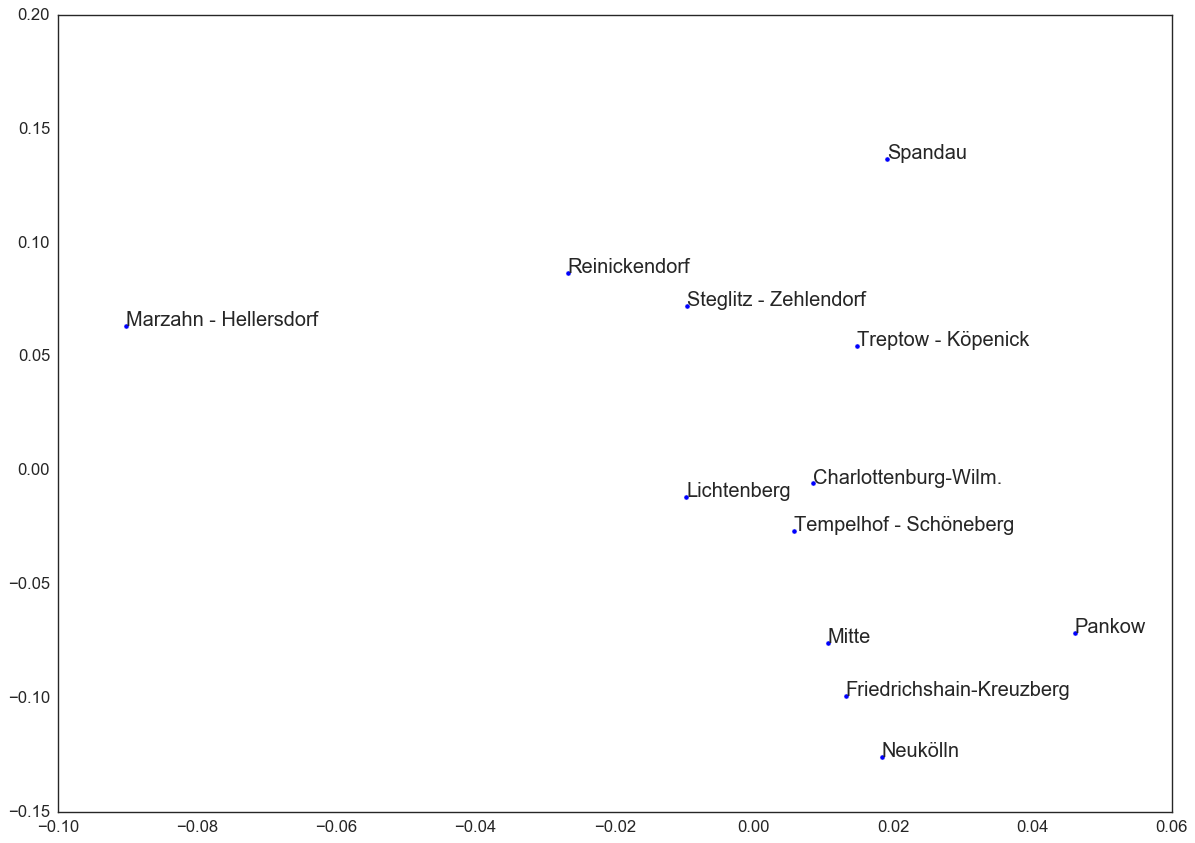

In [292]:
# counting cosine similarity and drawing results with help of MDS
dist = 1 - cosine_similarity(dtm)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]
names = listings_agg['neighbourhood_group']


for x, y, name in zip(xs, ys, names):
    plt.scatter(x, y)
    plt.text(x, y, name)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size
plt.style.use('seaborn-white')
plt.savefig('mapping.png', bbox_inches = 'tight')

## What are the distinctive words for the descriptions of neighbourhoods related to different clusters?

In [12]:
# function which calculates log-likelihood ratio and draws the most distinctive words
def loglike_compare(df, neighborhoods, text, words_threshold, num_words, save = True, name = 'output'):
    
    # creating document-term matrix
    listings_chosen = df[df['neighbourhood_group'].isin(neighborhoods)]
    labels = listings_chosen['neighbourhood_group'].apply(lambda x: 'first' if x == neighborhoods[0]
                                                          else 'second')
    vectorizer = CountVectorizer(input='content')
    dtm = vectorizer.fit_transform(listings_chosen[text])
    vocab = np.array(vectorizer.get_feature_names())
    dtm = dtm.toarray()
    words = vocab[np.sum(dtm, axis = 0) > words_threshold]
    
    # calculating log odds ratio
    X = dtm[:, np.in1d(vocab,words)]
    X = X.T + 1
    logs = np.log((X[:, labels == 'first'] / np.sum((dtm.T + 1)[:, labels == "first"])) /
                  (X[:, labels == 'second'] / np.sum((dtm.T + 1)[:, labels == "second"]))) 
    
    # creating a dataframe
    df = pd.DataFrame({'words':words, 'log':logs.flatten()})
    first = df.sort_values(by='log', ascending=True).head(num_words)
    first['district'] = np.repeat(neighborhoods[1], num_words)
    second = df.sort_values(by='log', ascending=False).head(num_words)
    second['district'] = np.repeat(neighborhoods[0], num_words)
    df = first.append(second)
    df = df.sort_values('log')
    
    # drawing a plot
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    a4_dims = (11.7, 8.27)
    fig, ax = pyplot.subplots(figsize=a4_dims)
    ax = sns.barplot(x="log", y="words", hue="district", data=df)
    ax.set(xlabel='Log-likelihood ratio', ylabel='Words')
    ax.text(0, 0, '')
    if save:
        ax.figure.savefig(name + '.png')   

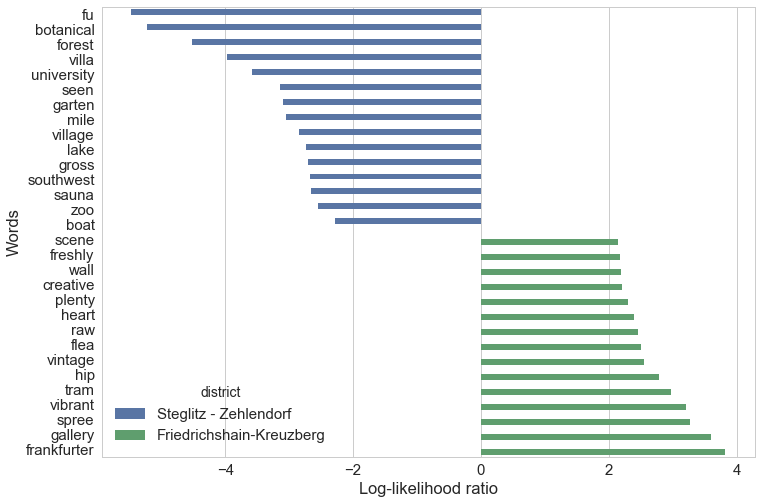

In [20]:
warnings.filterwarnings("ignore")
loglike_compare(listings_agg, ['Friedrichshain-Kreuzberg', 'Steglitz - Zehlendorf'], 'description_cleaned', 10, 15, 
               name = 'descriptions')

In [41]:
# looking at the context in which the words occur
list(listings['description'][(listings['neighbourhood_group'] == 'Friedrichshain-Kreuzberg') & 
                             (listings['description_cleaned'].str.contains('\sfrankfurter\s', regex=True))])[1]

"The pension is located in a ground floor apartment in front of a partly restored tenement house in a quiet side street. The apartment was lavish renovation in September 2005, specially converted to accommodate guests. Our guest room has its own mini kitchen with sink and hot water, 2 hotplates, refrigerator, coffee maker, toaster and kettle, and DBVT TV. To continue: 3 beds, couch sleeping max function as an extra bed for 2 persons, coffee table, wardrobe, shelving and dining area. 5 people The rental rates vary according to length of stay. In the vicinity there are the typical scene of Friedrichshain-bars, small shops selling food and beverages, secondhand goods, stores for gothic and punk. At the bakery around the corner, you can have breakfast from 6 clock, Saturdays and Sundays from 7 clock from 8 clock. The ring-center load in the near Frankfurter Allee and many other shops for a shopping spree. If that's not enough to drive the U-Bahn line 5 only 6 stations to Alexanderplatz wit

## How do positive reviews differ for neighborhoods related to different clusters?

In [107]:
reviews = pd.read_csv('./data/reviews.csv')

In [108]:
reviews.shape

(479327, 6)

In [109]:
reviews.head(1)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1944,7126992,2013-09-07,8207524,Mirko,I want to thank Laura&Emiliano for their hospi...


In [111]:
# joining reviews with neighbourhoods' names
reviews = pd.merge(reviews, listings[['id', 'neighbourhood_group']], how='left', left_on=['listing_id'], right_on=['id'])

In [112]:
# as the dataset is too big, let's work only with two needed neighbourhoods
reviews_filtered = reviews[reviews['neighbourhood_group'].isin(['Friedrichshain-Kreuzberg', 'Steglitz - Zehlendorf'])]

In [118]:
reviews_filtered.shape

(118155, 8)

In [81]:
nlp = en_core_web_sm.load()

In [119]:
# guests very often mention the names of hosts
# we need to exclude them from the texts, as they would become distinctive features for our neighbourhoods
def names_extractor(x):
    doc = nlp(x)
    entities = [(X.text, X.label_) for X in doc.ents]
    names = [t for t in entities if t[1] == 'PERSON']
    return [x[0] for x in names]

names_nested = reviews_filtered['comments'].apply(lambda x: names_extractor(str(x)))

In [142]:
# making flatten list with unqiue names
names = [name.lower() for names in list(itertools.chain(names_nested)) for name in names]
names = set(names)

In [149]:
# removing non-english words, punctuation, numbers, stopwords, and names
def non_eng_rem(x):
    return " ".join(w.lower() for w in nltk.wordpunct_tokenize(x) \
         if w.lower() in words and w.lower() not in names and w.lower() not in stop_words and w.isalpha())

reviews_filtered['comments_cleaned'] = reviews_filtered['comments'].apply(lambda x: non_eng_rem(str(x)))
reviews_filtered = reviews_filtered.dropna(subset=['comments_cleaned'])

In [147]:
# employing sentiment analysis
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score.get('compound')

In [151]:
reviews_filtered['sentiment'] = reviews_filtered['comments_cleaned'].apply(lambda x: sentiment_analyzer_scores(x)) 

In [153]:
# leaving only positive reviews
good_reviews = reviews_filtered[(reviews_filtered['sentiment'] > 0)]

In [154]:
# aggregating positive reviews on the base of neighborhoods
reviews_agg = good_reviews.groupby('neighbourhood_group')['comments_cleaned'].apply(lambda x: ''.join(str(list(x)))).reset_index()

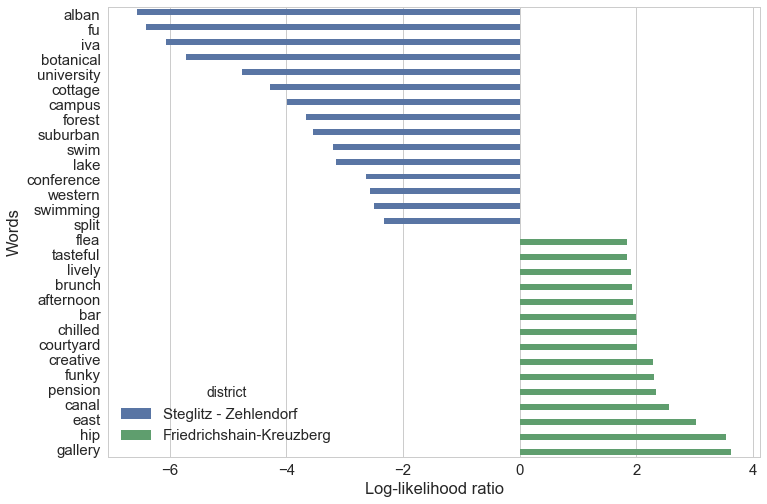

In [155]:
# calculating log-likelihood ration and drawing the most distinctive words
loglike_compare(reviews_agg, ['Friedrichshain-Kreuzberg', 'Steglitz - Zehlendorf'],'comments_cleaned', 10, 15, 
                name = 'reviews')

In [164]:
# looking at the context in which the words occur
list(good_reviews['comments'][(good_reviews['neighbourhood_group'] == 'Friedrichshain-Kreuzberg') & 
                             (good_reviews['comments_cleaned'].str.contains('\screative\s', regex = True))])[2]

"I stayed at Desiree's place for a couple of days and had a good time. The location is amazing, you can explore the alternative and creative side of Berlin and the apartment is super close to many nice places. The room was cozy, bright, stylish and warm and the landscape was unforgettable. Also Desiree was a lovely host, she was helpful and gracious in addition she definitely makes you feel at a wonderful place. I highly recommend Desiree's apartment."